<a href="https://colab.research.google.com/github/mayanjabbaale/Image-Captioning/blob/main/Image_Captioning_using_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setting Up Kaggle Dataset (Flickr8K Dataset)

In [1]:
from google.colab import  files
import kagglehub

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Saving kaggle.json to kaggle.json
Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


2. Visualizing the dataset

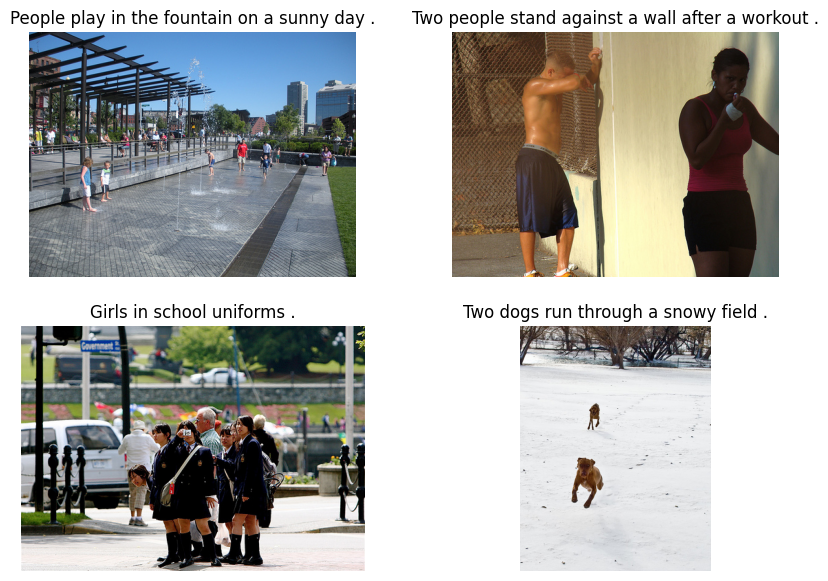

In [2]:
import pathlib
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np

images_dir = pathlib.Path(path)/ 'Images'
captions_file = pathlib.Path(path)/ 'captions.txt'

images = list(images_dir.glob("*.jpg"))
captions = []

with open(captions_file, "r") as f:
  for line in f:
    captions.append(line.strip())

del captions[0]

def process_image_captions(input_data):
    result_dict = {}

    if isinstance(input_data, str):
        lines = input_data.strip().split('\n')
    else:
        lines = input_data

    for line in lines:
        # Skip empty lines
        if not line.strip():
            continue

        # Split ONLY on the first comma found (maxsplit=1)
        # This prevents issues if the caption itself contains commas
        parts = line.split(',', 1)

        if len(parts) == 2:
            image_name = parts[0].strip()
            caption = parts[1].strip()
            result_dict[image_name] = caption

    return result_dict

img_caption_dict = process_image_captions(captions)

np.random.seed(5)
fig = plt.figure(figsize=(10, 7))
rows, cols = 2, 2
for i in range(1, rows * cols + 1):
    random_idx = np.random.randint(0, len(images), size=[1]).item()
    img = Image.open(images[random_idx])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    for img in img_caption_dict.keys():
      if img == images[random_idx].name:
        plt.title(img_caption_dict[img])
    plt.axis(False);


3. Preparing a PyTorch Dataset

In [3]:
import os
import re
import csv
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from collections import Counter
from PIL import Image
import numpy as np
import random

from tqdm import tqdm

In [4]:
EMBED_DIM = 256
HIDDEN_DIM = 512
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 50
MIN_WORD_FREQ = 1
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4

IMAGES_DIR = images_dir
TOKENS_FILE = captions_file

BEST_CHECKPOINT_PATH = "best_checkpoint.pth"
FINAL_MODEL_PATH = "final_model.pth"
VOCAB_PATH = "vocab.pkl"

RESUME = False

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

4. Creating the Vocabulary Class and Captions Parser

In [5]:
class Vocabulary:
  def __init__(self, freq_threshold=5):
    self.freq_threshold = freq_threshold
    self.itos = {0: "pad", 1: "startofseq", 2: "endofseq", 3: "unk"}
    self.stoi = {v: k for k, v in self.itos.items()}
    self.index = 4

  def __len__(self):
    return len(self.itos)

  def tokenizer(self, text):
    text = text.lower()
    tokens = re.findall(r'\w+', text)
    return tokens

  def build_vocabulary(self, sentence_list):
    frequencies = Counter()
    for sentence in sentence_list:
      tokens = self.tokenizer(sentence)
      frequencies.update(tokens)

    for word, freq in frequencies.items():
      if freq > self.freq_threshold:
        self.stoi[word] = self.index
        self.itos[self.index] = word
        self.index += 1

  def numericalize(self, text):
    tokens = self.tokenizer(text)
    numericalized = []
    for token in tokens:
      if token in self.stoi:
        numericalized.append(self.stoi[token])
      else:
        numericalized.append(self.stoi["unk"])
    return numericalized

def parse_tokens(csv_file):
  img_2_captions = {}
  with open(csv_file, "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
      if len(row) < 2:
        continue
      img_id, caption = row[0], row[1]
      if img_id not in img_2_captions:
        img_2_captions[img_id] = []
      img_2_captions[img_id].append(caption)
  return img_2_captions

5. Creating the PyTorch Dataset from the Flickr8k dataset

In [6]:
class Flickr8k_Dataset(Dataset):
  def __init__(self, img2captions, vocab, transform=None):
    self.img2captions = []
    self.transform = transform
    self.vocab = vocab

    for img_id, caps in img2captions.items():
      for c in caps:
        self.img2captions.append((img_id, c))

  def __len__(self):
    return len(self.img2captions)

  def __getitem__(self, idx):
    img_id, caption = self.img2captions[idx]
    img_path = os.path.join(images_dir, img_id)
    image = Image.open(img_path).convert("RGB")
    if self.transform:
      image = self.transform(image)

    numerical_caption = [self.vocab.stoi["startofseq"]]
    numerical_caption += self.vocab.numericalize(caption)
    numerical_caption.append(self.vocab.stoi["endofseq"])

    return image, torch.tensor(numerical_caption, dtype=torch.long)


def collate_fn(batch):
  batch.sort(key=lambda x: len(x[1]), reverse=True)
  images = [item[0] for item in batch]
  captions = [item[1] for item in batch]
  lengths = [len(cap) for cap in captions]
  max_len = max(lengths)

  padded_captions = torch.zeros((len(captions), max_len), dtype=torch.long)
  for i, cap in enumerate(captions):
    end = lengths[i]
    padded_captions[i, :end] = cap[:end]

  images = torch.stack(images, dim=0)
  return images, padded_captions, lengths

6. Encoder and Decoder model definitions

In [7]:
class ResNetEncoder(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    for param in resnet.parameters():
      param.requires_grad = False

    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
    self.batch_norm = nn.BatchNorm1d(embed_dim, momentum=0.01)

  def forward(self, images):
    with torch.no_grad():
      features = self.resnet(images)
    features = features.view(features.size(0), -1)
    features = self.fc(features)
    features = self.batch_norm(features)

    return features

class DecoderLSTM(nn.Module):
  def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers=1):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, features, captions):
    captions_in = captions[:, :-1]
    emb = self.embedding(captions_in)
    features = features.unsqueeze(1)
    lstm_input = torch.cat((features, emb), dim=1)
    outputs, _ = self.lstm(lstm_input)
    logits = self.fc(outputs)

    return logits

7. Combined Model

In [8]:
class ImageCaptionModel(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs

8. Training Pipeline

In [9]:
def train(model, dataloader, loss_fn, optimizer, vocab_size, epoch):
  model.train()
  total_loss = 0
  progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}', unit="batch")

  for images, captions, _lengths in progress_bar:
    images = images.to(DEVICE)
    captions = captions.to(DEVICE)

    optimizer.zero_grad()
    outputs = model(images, captions)
    outputs = outputs[:, 1:, :].contiguous().view(-1, vocab_size)
    targets = captions[:, 1:].contiguous().view(-1)

    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})
  avg_loss = total_loss / len(dataloader)

  return avg_loss

def validate(model, dataloader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.inference_mode():
        for images, captions, _lengths in dataloader:
            images = images.to(DEVICE)
            captions = captions.to(DEVICE)
            outputs = model(images, captions)
            outputs = outputs[:, 1:, :].contiguous().view(-1, vocab_size)
            targets = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_val_loss = total_loss / len(dataloader)
    return avg_val_loss

In [10]:
if not RESUME:
  imgid2captions = parse_tokens(TOKENS_FILE)

  all_captions = []
  for caps in imgid2captions.values():
    for caption in caps:
      all_captions.append(caption)

  vocab = Vocabulary(freq_threshold=MIN_WORD_FREQ)
  vocab.build_vocabulary(all_captions)

  with open(VOCAB_PATH, "wb") as f:
    pickle.dump(vocab, f)
  print("Vocabulary saved to:", VOCAB_PATH)

  vocab_size = len(vocab)
  print(f"Vocabulary size: {vocab_size}")

  img_ids = list(imgid2captions.keys())
  random.shuffle(img_ids)
  split_idx = int(0.8 * len(img_ids))
  train_ids = img_ids[:split_idx]
  val_ids = img_ids[split_idx:]

  train_dict = {iid: imgid2captions[iid] for iid in train_ids}
  val_dict = {iid: imgid2captions[iid] for iid in val_ids}

else:
  with open(VOCAB_PATH, "rb") as f:
    vocab = pickle.load(f)
  vocab_size = len(vocab)
  print(f'Resuming training. Vocab size: {vocab_size}')

  imgid2captions = parse_tokens(TOKENS_FILE)
  img_ids = list(imgid2captions.keys())
  random.shuffle(img_ids)
  split_idx = int(0.8 * len(img_ids))
  train_ids = img_ids[:split_idx]
  val_ids = img_ids[split_idx:]

  train_dict = {iid: imgid2captions[iid] for iid in train_ids}
  val_dict = {iid: imgid2captions[iid] for iid in val_ids}

Vocabulary saved to: vocab.pkl
Vocabulary size: 5156


9. Creating datasets & loaders

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = Flickr8k_Dataset(train_dict, vocab, transform=transform)
val_data = Flickr8k_Dataset(val_dict, vocab, transform=transform)

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn,
                              drop_last=False,
                              num_workers=NUM_WORKERS)

val_dataloader = DataLoader(val_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              drop_last=False,
                              num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
encoder = ResNetEncoder(EMBED_DIM)
decoder = DecoderLSTM(EMBED_DIM, HIDDEN_DIM, vocab_size)
model = ImageCaptionModel(encoder, decoder).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.")

loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.stoi["pad"])
parameters = list(model.decoder.parameters()) + list(model.encoder.fc.parameters()) + list(model.encoder.batch_norm.parameters())
optimizer = optim.Adam(parameters, lr=LEARNING_RATE)

start_epoch = 0
best_val_loss = float("inf")

if RESUME and os.path.exists(BEST_CHECKPOINT_PATH):
  print("Resuming from checkpoint:", BEST_CHECKPOINT_PATH)
  checkpoint = torch.load(BEST_CHECKPOINT_PATH, map_location=DEVICE)
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  start_epoch = checkpoint["epoch"] + 1
  best_val_loss = checkpoint["best_val_loss"]
  print(f"Resuming at epoch {start_epoch}, best_val_loss do fat: {best_val_loss:4f}")
elif RESUME:
  print(f"Warning: {BEST_CHECKPOINT_PATH} not found. Starting fresh...")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


29,575,012 total parameters.
6,066,980 training parameters.


10. Training Loop

In [ ]:
try:
  for epoch in range(start_epoch, EPOCHS):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, vocab_size, epoch)
    val_loss = validate(model, val_dataloader, loss_fn, vocab_size)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      checkpoint_dict = {
          "epoch": epoch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "best_val_loss": best_val_loss
      }
      torch.save(checkpoint_dict, BEST_CHECKPOINT_PATH)
      print(f"New best model saved -> {BEST_CHECKPOINT_PATH} (val_loss={val_loss:.4f})")

    final_checkpoint_dict = {
        "model_state_dict": model.state_dict(),
    }
    torch.save(final_checkpoint_dict, FINAL_MODEL_PATH)
except KeyboardInterrupt:
  print("\nTraining interrupted by User. Best checkpoint is alreasy saved if it improved during training.")

print(f"\nFinal model weights saved to {FINAL_MODEL_PATH}")
print(f"Best val_loss={best_val_loss:.4f} (checkpoint at {BEST_CHECKPOINT_PATH})")

Epoch 1: 100%|██████████| 506/506 [03:23<00:00,  2.49batch/s, Loss=2.5777]


[Epoch 1/50] Train Loss: 3.1136 | Val Loss: 2.3246
New best model saved -> best_checkpoint.pth (val_loss=2.3246)


Epoch 2: 100%|██████████| 506/506 [03:20<00:00,  2.53batch/s, Loss=1.8837]


[Epoch 2/50] Train Loss: 2.1961 | Val Loss: 2.0828
New best model saved -> best_checkpoint.pth (val_loss=2.0828)


Epoch 3: 100%|██████████| 506/506 [03:14<00:00,  2.61batch/s, Loss=1.9830]


[Epoch 3/50] Train Loss: 2.0030 | Val Loss: 1.9557
New best model saved -> best_checkpoint.pth (val_loss=1.9557)


Epoch 4: 100%|██████████| 506/506 [03:14<00:00,  2.60batch/s, Loss=1.9284]


[Epoch 4/50] Train Loss: 1.8848 | Val Loss: 1.8672
New best model saved -> best_checkpoint.pth (val_loss=1.8672)


Epoch 5: 100%|██████████| 506/506 [03:14<00:00,  2.60batch/s, Loss=1.6990]


[Epoch 5/50] Train Loss: 1.7938 | Val Loss: 1.8019
New best model saved -> best_checkpoint.pth (val_loss=1.8019)


Epoch 6: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.6657]


[Epoch 6/50] Train Loss: 1.7215 | Val Loss: 1.7508
New best model saved -> best_checkpoint.pth (val_loss=1.7508)


Epoch 7: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.4946]


[Epoch 7/50] Train Loss: 1.6599 | Val Loss: 1.7139
New best model saved -> best_checkpoint.pth (val_loss=1.7139)


Epoch 8: 100%|██████████| 506/506 [03:11<00:00,  2.64batch/s, Loss=1.4022]


[Epoch 8/50] Train Loss: 1.6000 | Val Loss: 1.6846
New best model saved -> best_checkpoint.pth (val_loss=1.6846)


Epoch 9: 100%|██████████| 506/506 [03:14<00:00,  2.61batch/s, Loss=1.9726]


[Epoch 9/50] Train Loss: 1.5534 | Val Loss: 1.6591
New best model saved -> best_checkpoint.pth (val_loss=1.6591)


Epoch 10: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.3439]


[Epoch 10/50] Train Loss: 1.5091 | Val Loss: 1.6430
New best model saved -> best_checkpoint.pth (val_loss=1.6430)


Epoch 11: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.4465]


[Epoch 11/50] Train Loss: 1.4730 | Val Loss: 1.6269
New best model saved -> best_checkpoint.pth (val_loss=1.6269)


Epoch 12: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.7903]


[Epoch 12/50] Train Loss: 1.4426 | Val Loss: 1.6150
New best model saved -> best_checkpoint.pth (val_loss=1.6150)


Epoch 13: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.5778]


[Epoch 13/50] Train Loss: 1.4067 | Val Loss: 1.6054
New best model saved -> best_checkpoint.pth (val_loss=1.6054)


Epoch 14: 100%|██████████| 506/506 [03:13<00:00,  2.62batch/s, Loss=1.6692]


[Epoch 14/50] Train Loss: 1.3773 | Val Loss: 1.5989
New best model saved -> best_checkpoint.pth (val_loss=1.5989)


Epoch 15: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.3351]


[Epoch 15/50] Train Loss: 1.3569 | Val Loss: 1.5909
New best model saved -> best_checkpoint.pth (val_loss=1.5909)


Epoch 16: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.2498]


[Epoch 16/50] Train Loss: 1.3202 | Val Loss: 1.5858
New best model saved -> best_checkpoint.pth (val_loss=1.5858)


Epoch 17: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.4552]


[Epoch 17/50] Train Loss: 1.2940 | Val Loss: 1.5818
New best model saved -> best_checkpoint.pth (val_loss=1.5818)


Epoch 18: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.0185]


[Epoch 18/50] Train Loss: 1.2726 | Val Loss: 1.5773
New best model saved -> best_checkpoint.pth (val_loss=1.5773)


Epoch 19: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.0572]


[Epoch 19/50] Train Loss: 1.2457 | Val Loss: 1.5779


Epoch 20: 100%|██████████| 506/506 [03:13<00:00,  2.62batch/s, Loss=1.0307]


[Epoch 20/50] Train Loss: 1.2325 | Val Loss: 1.5761
New best model saved -> best_checkpoint.pth (val_loss=1.5761)


Epoch 21: 100%|██████████| 506/506 [03:13<00:00,  2.62batch/s, Loss=1.4602]


[Epoch 21/50] Train Loss: 1.2033 | Val Loss: 1.5739
New best model saved -> best_checkpoint.pth (val_loss=1.5739)


Epoch 22: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=0.9862]


[Epoch 22/50] Train Loss: 1.1840 | Val Loss: 1.5748


Epoch 23: 100%|██████████| 506/506 [03:13<00:00,  2.62batch/s, Loss=1.2480]


[Epoch 23/50] Train Loss: 1.1630 | Val Loss: 1.5760


Epoch 24: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.1870]


[Epoch 24/50] Train Loss: 1.1522 | Val Loss: 1.5749


Epoch 25: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.0536]


[Epoch 25/50] Train Loss: 1.1295 | Val Loss: 1.5772


Epoch 26: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.2094]


[Epoch 26/50] Train Loss: 1.1134 | Val Loss: 1.5810


Epoch 27: 100%|██████████| 506/506 [03:11<00:00,  2.64batch/s, Loss=1.0845]


[Epoch 27/50] Train Loss: 1.0967 | Val Loss: 1.5801


Epoch 28: 100%|██████████| 506/506 [03:14<00:00,  2.61batch/s, Loss=1.0776]


[Epoch 28/50] Train Loss: 1.0741 | Val Loss: 1.5858


Epoch 29: 100%|██████████| 506/506 [03:12<00:00,  2.62batch/s, Loss=1.3203]


[Epoch 29/50] Train Loss: 1.0580 | Val Loss: 1.5847


Epoch 30: 100%|██████████| 506/506 [03:12<00:00,  2.63batch/s, Loss=1.1085]


[Epoch 30/50] Train Loss: 1.0423 | Val Loss: 1.5852


Epoch 31: 100%|██████████| 506/506 [03:13<00:00,  2.62batch/s, Loss=1.0456]


[Epoch 31/50] Train Loss: 1.0253 | Val Loss: 1.5918


Epoch 32: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=0.8933]


[Epoch 32/50] Train Loss: 1.0138 | Val Loss: 1.5939


Epoch 33: 100%|██████████| 506/506 [03:13<00:00,  2.61batch/s, Loss=1.1545]


[Epoch 33/50] Train Loss: 0.9923 | Val Loss: 1.5963


Epoch 34: 100%|██████████| 506/506 [03:12<00:00,  2.62batch/s, Loss=1.1490]


[Epoch 34/50] Train Loss: 0.9816 | Val Loss: 1.5994


Epoch 35: 100%|██████████| 506/506 [03:13<00:00,  2.62batch/s, Loss=1.3371]


[Epoch 35/50] Train Loss: 0.9718 | Val Loss: 1.6042


Epoch 36: 100%|██████████| 506/506 [03:14<00:00,  2.60batch/s, Loss=1.1769]


[Epoch 36/50] Train Loss: 0.9484 | Val Loss: 1.6104


Epoch 37: 100%|██████████| 506/506 [03:12<00:00,  2.62batch/s, Loss=0.9990]


[Epoch 37/50] Train Loss: 0.9405 | Val Loss: 1.6130


Epoch 38: 100%|██████████| 506/506 [03:09<00:00,  2.67batch/s, Loss=1.2552]


[Epoch 38/50] Train Loss: 0.9274 | Val Loss: 1.6168


Epoch 39:  32%|███▏      | 164/506 [01:03<01:42,  3.33batch/s, Loss=0.8896]

11. Inference – Generating some Image Captions

In [ ]:
!ls
import pickle
import gradio as gr
import re
from collections import Counter
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights

class Vocabulary:
  def __init__(self, freq_threshold=5):
      self.freq_threshold = freq_threshold
      self.itos = {0: "pad", 1: "startofseq", 2: "endofseq", 3: "unk"}
      self.stoi = {v: k for k, v in self.itos.items()}
      self.index = 4

  def __len__(self):
      return len(self.itos)

  def tokenizer(self, text):
      text = text.lower()
      tokens = re.findall(r"\w+", text)
      return tokens

  def build_vocabulary(self, sentence_list):
      frequencies = Counter()
      for sentence in sentence_list:
          tokens = self.tokenizer(sentence)
          frequencies.update(tokens)

      for word, freq in frequencies.items():
          if freq >= self.freq_threshold:
              self.stoi[word] = self.index
              self.itos[self.index] = word
              self.index += 1

  def numericalize(self, text):
      tokens = self.tokenizer(text)
      numericalized = []
      for token in tokens:
          if token in self.stoi:
              numericalized.append(self.stoi[token])
          else:
              numericalized.append(self.stoi["unk"])
      return numericalized


EMBED_DIM = 256
HIDDEN_DIM = 512
MAX_SEQ_LENGTH = 25
DEVICE = "cpu"

MODEL_SAVE_PATH = "final_model.pth"

with open("vocab.pkl", "rb") as f:
  vocab = pickle.load(f)

print(vocab)

vocab_size = len(vocab)

print(vocab_size)

class ResNetEncoder(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in resnet.parameters():
      param.requires_grad = False

    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
    self.batch_norm = nn.BatchNorm1d(embed_dim, momentum=0.01)

  def forward(self, images):
    with torch.inference_mode():
      features = self.resnet(images)
    features = features.view(features.size(0), -1)
    features = self.fc(features)
    features = self.batch_norm(features)

    return features

class DecoderLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
      captions_in = captions[:, :-1]
      emb = self.embedding(captions_in)
      features = features.unsqueeze(1)
      lstm_input = torch.cat((features, emb), dim=1)
      outputs, _ = self.lstm(lstm_input)
      logits = self.fc(outputs)

      return logits

    def generate(self, features, max_len=20):
        batch_size = features.size(0)
        hidden_state = torch.zeros((1, batch_size, self.lstm.hidden_size)).to(features.device)
        cell_state = torch.zeros((1, batch_size, self.lstm.hidden_size)).to(features.device)
        states = (hidden_state, cell_state)

        generated_captions = []

        lstm_input = features.unsqueeze(1) # (batch_size, 1, embed_dim)
        output, states = self.lstm(lstm_input, states)
        logits = self.fc(output.squeeze(1)) # (batch_size, vocab_size)

        # Predict the first word (greedy approach)
        predicted_token = logits.argmax(dim=1)
        generated_captions.append(predicted_token.item())

        # for subsequent steps, use the predicted word as input
        input_token = predicted_token.unsqueeze(0) # (batch_size, 1)

        # Iterate to generate the rest of the caption
        for _ in range(1, max_len): # Start from 1, since the first word is already generated
            # If <endofseq> was predicted in the previous step, stop
            if generated_captions[-1] == vocab.stoi["endofseq"]:
                break

            input_token_embedded = self.embedding(input_token) # (batch_size, 1, embed_dim)

            output, states = self.lstm(input_token_embedded, states) # Pass previous states
            logits = self.fc(output.squeeze(1))
            predicted_token = logits.argmax(dim=1)
            generated_captions.append(predicted_token.item())

            input_token = predicted_token.unsqueeze(0)

        return generated_captions

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def generate(self, images, max_len=MAX_SEQ_LENGTH):
        features = self.encoder(images)
        return self.decoder.generate(features, max_len=max_len)

def load_trained_model():
    encoder = ResNetEncoder(embed_dim=EMBED_DIM)
    decoder = DecoderLSTM(EMBED_DIM, HIDDEN_DIM, vocab_size)
    model = ImageCaptioningModel(encoder, decoder).to(DEVICE)

    state_dict = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict['model_state_dict'])
    model.eval()
    return model

model = load_trained_model()

transform_inference = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ]
)

def generate_caption_for_image(img):
    pil_img = img.convert("RGB")
    img_tensor = transform_inference(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output_indices = model.generate(img_tensor, max_len=MAX_SEQ_LENGTH)

    result_words = []
    end_token_idx = vocab.stoi["endofseq"]
    for idx in output_indices:
        if idx == end_token_idx:
            break
        word = vocab.itos.get(idx, "unk")
        if word not in ["startofseq", "pad", "endofseq"]:
            result_words.append(word)
    return " ".join(result_words)

def main():
    iface = gr.Interface(
        fn=generate_caption_for_image,
        inputs=gr.Image(type="pil"),
        outputs=[gr.Textbox(label="Generated Caption", lines=4)],
        title="Image Captioning (ResNet + LSTM)",
        description="Upload an image to get a generated caption from the trained model.",
        article="Created By Mayanja Pius"
    )
    iface.launch(share=True, debug=False)

if __name__ == "__main__":
  main()

Creating Gradio app folder to push to HuggingFace spaces.

In [ ]:
import shutil
from pathlib import Path

demo_path = Path("demos/captioning/")

# Remove files that might already exist there and create new directory
if demo_path.exists():
    shutil.rmtree(demo_path)
# If the file doesn't exist, create it anyway
demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/captioning/

In [ ]:
# Create a source path for our target model
model_path = "final_model.pth"
vocab_path = "vocab.pkl"

# Create a destination path for our target model
model_destination = demo_path / model_path
vocab_destination = demo_path / vocab_path

# Try to move the file
try:
    print(f"[INFO] Attempting to move {model_path} and {vocab_path} to {model_destination} and {vocab_destination}")

    # Move the model
    shutil.copy(src=model_path,
                dst=model_destination)
    shutil.copy(src=vocab_path,
                dst=vocab_destination)

    print(f"[INFO] Model and Vocab move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {model_destination}: {model_destination.exists()}")

In [ ]:
%%writefile demos/captioning/model.py


import pickle
import gradio as gr
import re
from collections import Counter
import torch, torchvision, collections
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights

class Vocabulary:
  def __init__(self, freq_threshold=5):
      self.freq_threshold = freq_threshold
      self.itos = {0: "pad", 1: "startofseq", 2: "endofseq", 3: "unk"}
      self.stoi = {v: k for k, v in self.itos.items()}
      self.index = 4

  def __len__(self):
      return len(self.itos)

  def tokenizer(self, text):
      text = text.lower()
      tokens = re.findall(r"\w+", text)
      return tokens

  def build_vocabulary(self, sentence_list):
      frequencies = Counter()
      for sentence in sentence_list:
          tokens = self.tokenizer(sentence)
          frequencies.update(tokens)

      for word, freq in frequencies.items():
          if freq >= self.freq_threshold:
              self.stoi[word] = self.index
              self.itos[self.index] = word
              self.index += 1

  def numericalize(self, text):
      tokens = self.tokenizer(text)
      numericalized = []
      for token in tokens:
          if token in self.stoi:
              numericalized.append(self.stoi[token])
          else:
              numericalized.append(self.stoi["unk"])
      return numericalized


EMBED_DIM = 256
HIDDEN_DIM = 512
MAX_SEQ_LENGTH = 25
DEVICE = "cpu"

MODEL_SAVE_PATH = "final_model.pth"

with open("vocab.pkl", "rb") as f:
  vocab = pickle.load(f)

vocab_size = len(vocab)

class ResNetEncoder(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in resnet.parameters():
      param.requires_grad = True

    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
    self.batch_norm = nn.BatchNorm1d(embed_dim, momentum=0.01)

  def forward(self, images):
    with torch.inference_mode():
      features = self.resnet(images)
    features = features.view(features.size(0), -1)
    features = self.fc(features)
    features = self.batch_norm(features)

    return features

class DecoderLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
      captions_in = captions[:, :-1]
      emb = self.embedding(captions_in)
      features = features.unsqueeze(1)
      lstm_input = torch.cat((features, emb), dim=1)
      outputs, _ = self.lstm(lstm_input)
      logits = self.fc(outputs)

      return logits

    def generate(self, features, max_len=20):
        batch_size = features.size(0)
        hidden_state = torch.zeros((1, batch_size, self.lstm.hidden_size)).to(features.device)
        cell_state = torch.zeros((1, batch_size, self.lstm.hidden_size)).to(features.device)
        states = (hidden_state, cell_state)

        generated_captions = []

        lstm_input = features.unsqueeze(1) # (batch_size, 1, embed_dim)
        output, states = self.lstm(lstm_input, states)
        logits = self.fc(output.squeeze(1)) # (batch_size, vocab_size)

        # Predict the first word (greedy approach)
        predicted_token = logits.argmax(dim=1)
        generated_captions.append(predicted_token.item())

        # for subsequent steps, use the predicted word as input
        input_token = predicted_token.unsqueeze(0) # (batch_size, 1)

        # Iterate to generate the rest of the caption
        for _ in range(1, max_len): # Start from 1, since the first word is already generated
            # If <endofseq> was predicted in the previous step, stop
            if generated_captions[-1] == vocab.stoi["endofseq"]:
                break

            input_token_embedded = self.embedding(input_token) # (batch_size, 1, embed_dim)

            output, states = self.lstm(input_token_embedded, states) # Pass previous states
            logits = self.fc(output.squeeze(1))
            predicted_token = logits.argmax(dim=1)
            generated_captions.append(predicted_token.item())

            input_token = predicted_token.unsqueeze(0)

        return generated_captions

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def generate(self, images, max_len=MAX_SEQ_LENGTH):
        features = self.encoder(images)
        return self.decoder.generate(features, max_len=max_len)

def load_trained_model():
    encoder = ResNetEncoder(embed_dim=EMBED_DIM)
    decoder = DecoderLSTM(EMBED_DIM, HIDDEN_DIM, vocab_size)
    model = ImageCaptioningModel(encoder, decoder).to(DEVICE)

    state_dict = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict['model_state_dict'])
    model.eval()
    return model

model = load_trained_model()

transform_inference = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ]
)

print(pickle.__version__, gr.__version__, re.__version__, torch.__version__, torchvision.__version__, collections.__version__)
!ls demos/captioning

In [ ]:
%%writefile demos/captioning/app.py

from model import transform_inference, model, vocab, DEVICE, MAX_SEQ_LENGTH
import torch
import gradio as gr

def generate_caption_for_image(img):
    pil_img = img.convert("RGB")
    img_tensor = transform_inference(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output_indices = model.generate(img_tensor, max_len=MAX_SEQ_LENGTH)

    result_words = []
    end_token_idx = vocab.stoi["endofseq"]
    for idx in output_indices:
        if idx == end_token_idx:
            break
        word = vocab.itos.get(idx, "unk")
        if word not in ["startofseq", "pad", "endofseq"]:
            result_words.append(word)
    return " ".join(result_words)

iface = gr.Interface(
    fn=generate_caption_for_image,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(label="Generated Caption", lines=4)],
    title="Image Captioning (ResNet + LSTM)",
    description="Upload an image to get a generated caption from the trained model.",
    article="Created By Mayanja Pius")

iface.launch(share=True, debug=False)

In [ ]:
%%writefile demos/captioning/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

In [ ]:
!ls demos/captioning/

In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/captioning && zip -r ../Image-Captioning.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/Image-Captioning.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")